# Data Plotting with PowerShell, Jupyter, VSCode, ScottPlot
Some explorations of plotting things in VSCode Jupyter notebooks (.NET Interactive kernel) using PowerShell and the open source package [ScottPlot](https://scottplot.net/)

**Table of contents**<a id='toc0_'></a>    
- [Initialization](#toc1_)    
- [Examples](#toc2_)    
  - [Scatter](#toc2_1_)    
  - [Bar with Values](#toc2_2_)    
  - [Stacked Bar](#toc2_3_)    
  - [Radial Gauge](#toc2_4_)    
  - [Pie Chart](#toc2_5_)    
- [Other Info](#toc3_)    
  - [Package Install in Polyglot Notebook](#toc3_1_)    
- [Explicit / Manual HTML creation invocation](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Initialization](#toc0_)
Ensure the ScottPlot PSResource is available for this session

In [1]:
#!csharp
// install the package most simply via '#r' "magic" notebook command (available in C#), getting pkg from nuget.org
#r "nuget:ScottPlot"
#!pwsh
## add the class to the PS session
Add-Type -AssemblyName ScottPlot

Installed Packages ScottPlot, 4.1.70

[Optional] Simplify graph output display by registering a DotNet-Interactive Formatter

We can leverage the `Out-Display` cmdlet for easy displaying of plots/graphs by first registring a Formatter for the object type (Note: the `Out-Display` cmdlet is from the auto-available `Microsoft.DotNet.Interactive.PowerShell` module in VSCode).

> **Note:** If we choose _not_ to register such a formatter, we would need to invoke the `HTML()` method of the .NET Interative kernel each time. Not horrible, but a bit more manual. See [Explicit / Manual HTML creation invocation](#toc4_) below for an example of this manual-ness.

In [2]:
## register a Formatter, so can just pipe ScotPlot objects to Out-Display; props to following site for info on .NET Action items: https://www.reza-aghaei.com/net-action-func-delegate-lambda-expression-in-powershell/
## scriptblock to use for the System.Action
$sbWriteHtml = {param([ScottPlot.Plot]$plot, [System.IO.TextWriter]$writer) $writer.Write($plot.GetImageHtml())}
## actually register the formatter for the given object type
[Microsoft.DotNet.Interactive.Formatting.Formatter]::Register[ScottPlot.Plot]([System.Action[ScottPlot.Plot,System.IO.TextWriter]]$sbWriteHtml, [Microsoft.DotNet.Interactive.Formatting.HtmlFormatter]::MimeType)
## see what are the registered formatters for the given object type
[Microsoft.DotNet.Interactive.Formatting.Formatter]::RegisteredFormatters($false) | Where-Object {$_.Type.FullName -eq "ScottPlot.Plot"}


MimeType  Type
--------  ----
text/html ScottPlot.Plot



## <a id='toc2_'></a>[Examples](#toc0_)
Some examples of using the package to plot/graph some data

### <a id='toc2_1_'></a>[Scatter](#toc0_)
Just a trivial plot to show the mechanics of creating a new Plot object, adding a scatter plot, and rendering the plot as HTML in the notebook


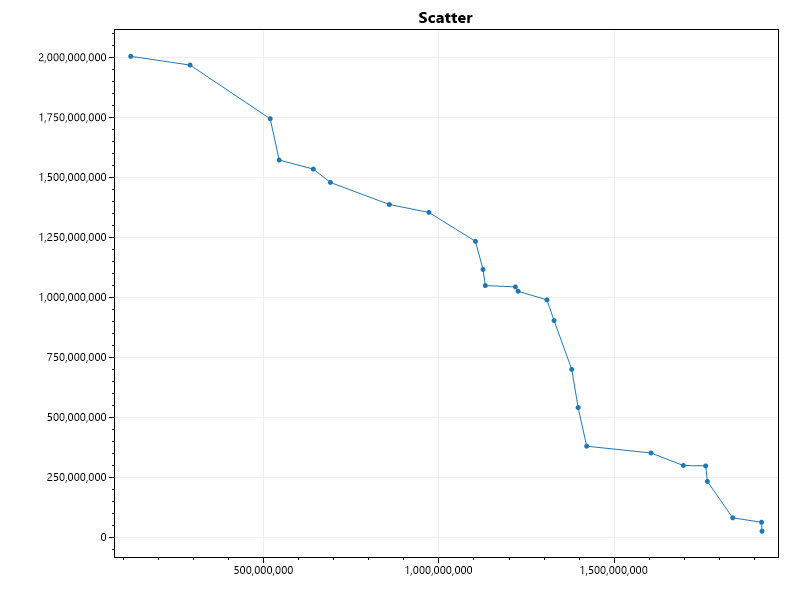

In [4]:
$dataX = Get-Random -Count 25 | Sort-Object
$dataY = Get-Random -Count 25 | Sort-Object -Descending:$true
($plt = [ScottPlot.Plot]::new()).Title("Scatter", $true, $null, $null)
$plt.AddScatter($dataX, $dataY) | Out-Null
$plt | Out-Display

### <a id='toc2_2_'></a>[Bar with Values](#toc0_)


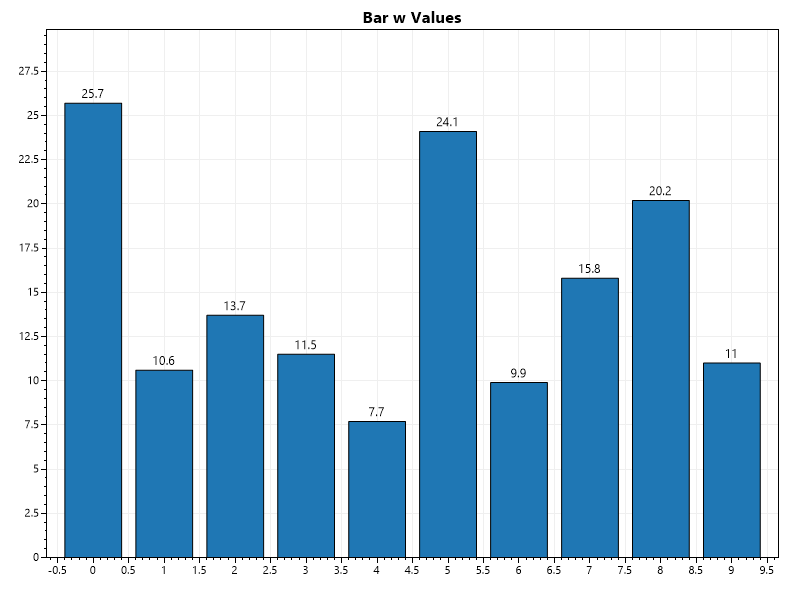

In [5]:
# https://scottplot.net/cookbook/4.1/category/plottable-bar-graph/#values-above-bars
($plt = [ScottPlot.Plot]::new()).Title("Bar w Values", $true, $null, $null)

$values = Get-Random -Count 10 -Minimum 6.4 -Maximum 27.4 | Foreach-Object {[Math]::Round($_, 1)}

# add a bar graph to the plot and enable values to be displayed above each bar
$plt.AddBar($values).ShowValuesAboveBars = $true

# adjust axis limits so there is no padding below the bar graph
$plt.SetAxisLimits($null, $null, ($intYMin = 0))

$plt | Out-Display

### <a id='toc2_3_'></a>[Stacked Bar](#toc0_)


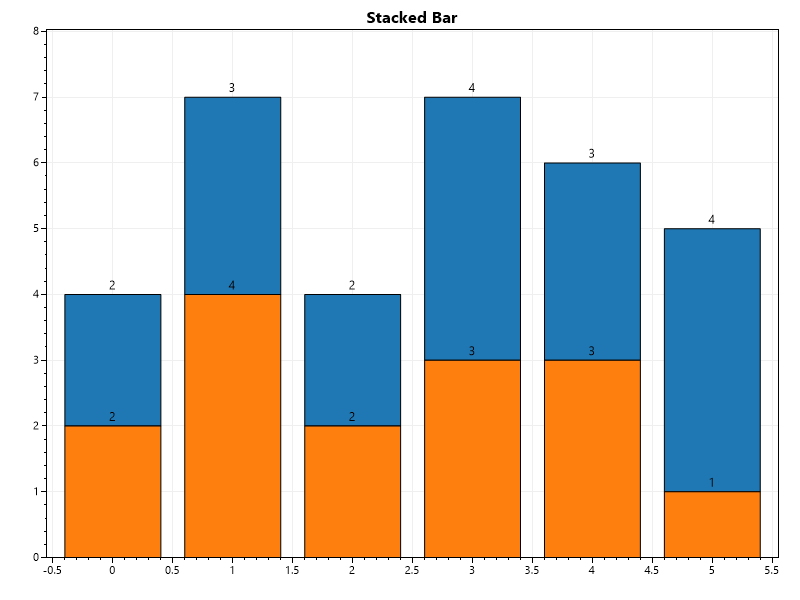

In [8]:
# https://scottplot.net/cookbook/4.1/category/plottable-bar-graph/#stacked-bar-graphs
($plt = [ScottPlot.Plot]::new()).Title("Stacked Bar", $true, $null, $null)

# create sample data
$sbMakeSampleData = {Get-Random -Count 6 -Minimum 1 -Maximum 5}
$valuesA = & $sbMakeSampleData; $valuesB = & $sbMakeSampleData

#region for stacking via barplot object's ValueOffsets
($barplotB, $barplotA = $valuesB, $valuesA | ForEach-Object {$plt.AddBar($_)}) | Foreach-Object {$_.ShowValuesAboveBars = $true}
## adjust the B barplot's values' y-offets by the y values in valuesA
$barplotB.ValueOffsets = $valuesA
#endregion for stacking via barplot object's ValueOffsets

# adjust axis limits so there is no padding below the bar graph
$plt.SetAxisLimits($null, $null, ($intYMin = 0))

$plt | Out-Display

### <a id='toc2_4_'></a>[Radial Gauge](#toc0_)


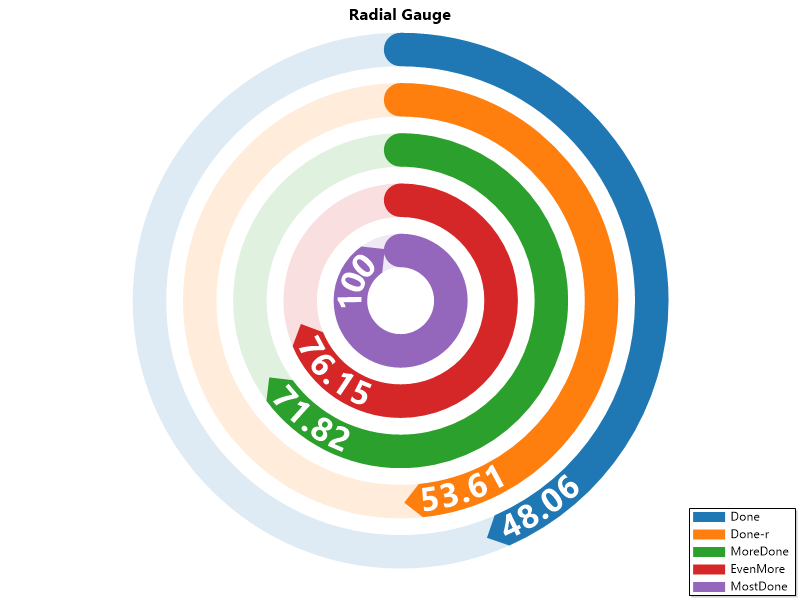

In [10]:
# https://scottplot.net/cookbook/4.1/category/plottable-radialgauge/#radial-gauge
($plt = [ScottPlot.Plot]::new()).Title("Radial Gauge", $true, $null, $null)
$values = ($intMax = 10000), (Get-Random -Minimum 5 -Maximum $intMax -Count 4) | Foreach-Object {$_} | ForEach-Object {$_ / 100} | Sort-Object
$oRadialGaugePlot = $plt.AddRadialGauge($values)
$oRadialGaugePlot.OrderInsideOut = $false
$oRadialGaugePlot.MaximumAngle = 325
$oRadialGaugePlot.Labels = Write-Output Done Done-r MoreDone EvenMore MostDone
$plt.Legend($true, $null) | Out-Null

$plt | Out-Display

### <a id='toc2_5_'></a>[Pie Chart](#toc0_)


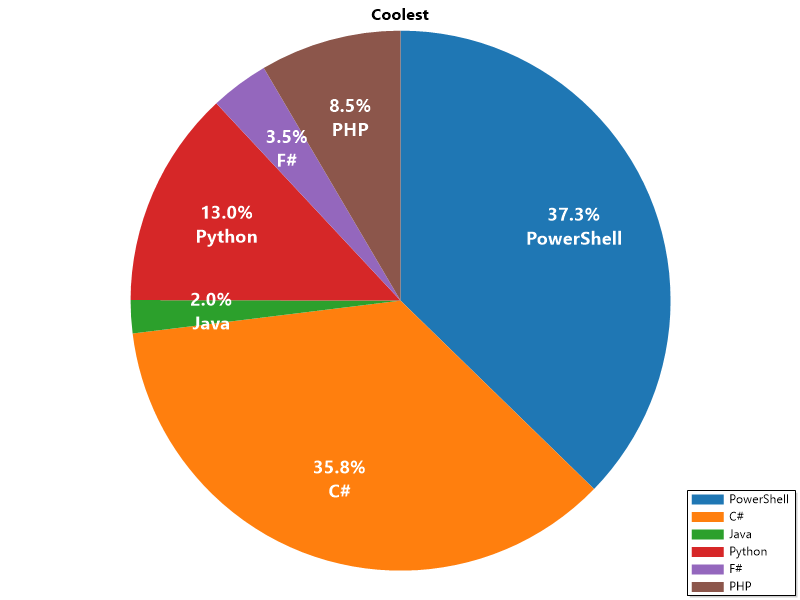

In [11]:
# https://scottplot.net/cookbook/4.1/category/plottable-pie/#label-everything
($plt = [ScottPlot.Plot]::new()).Title("Coolest", $true, $null, $null)
$hshDater = [ordered]@{PowerShell = 811; "C#" = 778; Java = 43; Python = 283; "F#" = 76; PHP = 184}
$pie = $plt.AddPie($hshDater.Values)
$pie.SliceLabels = $hshDater.Keys
$pie.ShowPercentages = $true
# $pie.ShowValues = $true
$pie.ShowLabels = $true
$plt.Legend($true, $null) | Out-Null

$plt | Out-Display

## <a id='toc3_'></a>[Other Info](#toc0_)
Some other general info.

### <a id='toc3_1_'></a>[Package Install in Polyglot Notebook](#toc0_)
.NET Interactive enables easy NuGet package download/import into the session via the `#r` "magic" command. See the .NET Interactive docs at [Working with NuGet packages](https://github.com/dotnet/interactive/blob/main/docs/nuget-overview.md)

 We could, of course, write some PowerShell to do such things, but that we can easy switch between languages in Polyglot notebooks, we can use magic commands for quickness and then focus on the actually cool stuff more immediately 🏎

#### Example of Package install "explicitly"
For posterity, here is a bit of PowerShell that would achieve essentially the same as the `#r` magic command and subsequent `Add-Type` above. A bit more tedious, eh?

In [ ]:
## example of "manual" download/import of NuGet pkg from within PowerShell
## Note: Requires -Module Microsoft.PowerShell.PSResourceGet
## "install" (save) pkg one time per Jupyter kernel session
if (-not ('ScottPlot.Plot' -as [System.Type])) {
    ## uses nuget.org resource repo (expects repo to already be registered -- current URI is https://api.nuget.org/v3/index.json)
    Find-PSResource ScottPlot | Save-PSResource -Path ($oTmpDir = New-Item -ItemType Directory -Path (Join-Path ([System.IO.Path]::GetTempPath()) (New-Guid))) -TrustRepository -PassThru -OutVariable oNewPSResource -WarningAction:SilentlyContinue
    ## then, import the module
    Import-Module -Name (Join-Path $oTmpDir $oNewPSResource.Name $oNewPSResource.Version lib\net6.0\ScottPlot.dll)
}
else {Write-Verbose -Verbose -Message "Great -- module already available. Let's plot!"}

### <a id='toc4_'></a>[Explicit / Manual HTML creation invocation](#toc0_)
As mentioned above, we could also use the `HTML()` method of the .NET Interactive kernel to prepare our goodness for proper display in the notebook. For posterity, here is the relevant bits of doing so:


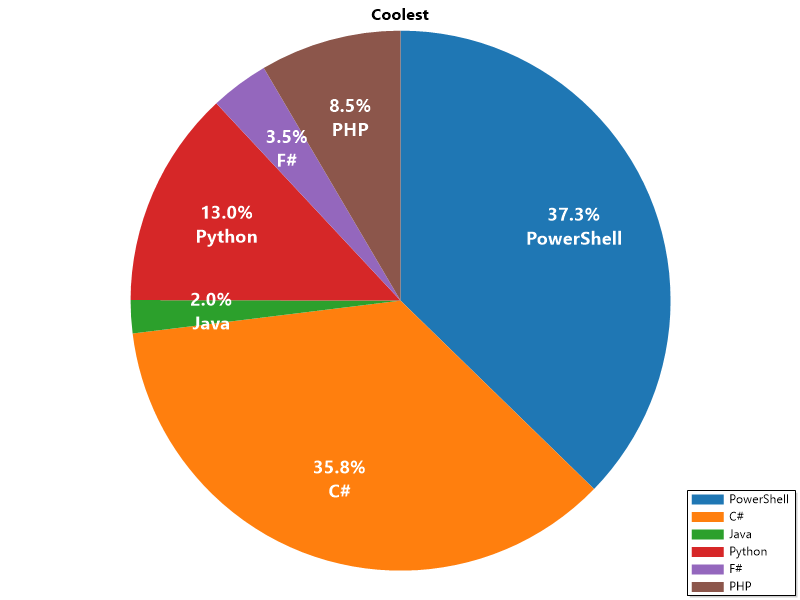

In [12]:
## use the HTML method of the Kernel class to create an object for proper notebook display
[Microsoft.DotNet.Interactive.Kernel]::HTML($plt.GetImageHTML()) | Out-Display